**Supervised Contrastive Learning**

* Paper: https://arxiv.org/abs/2004.11362
* Original code: https://github.com/google-research/google-research/tree/master/supcon
* Official pytorch code: https://github.com/HobbitLong/SupContrast

In [1]:
%reload_ext autoreload
%autoreload 2
from fastai.vision.all import *

# Data

In [2]:
path = untar_data(URLs.CIFAR)

In [3]:
class PairTensorImage(TensorImage): pass

class DoubleAugment(DisplayedTransform):
    def __init__(self, enable=True): store_attr()
    def encodes(self, x:TensorImage): return PairTensorImage(x.repeat_interleave(2, dim=0) if self.enable else x)
    def encodes(self, x): return x.repeat_interleave(2, dim=0) if self.enable else x
    @contextmanager
    def disabled(self):
        if not self.enable: return
        self.enable = False
        try: yield
        finally: self.enable = True

In [4]:
tst = TensorImage(PILImage.create(get_image_files(path)[1000]))[None]
f = DoubleAugment()
t = f(tst)
test_eq(tst.size(0), t.size(0)/2)
test_eq(t[0], t[1])

In [5]:
class ContrastiveCategorize(Categorize):
    def decodes(self, o): return Category(self.vocab[o]),o

def ConstrastiveCategoryBlock(vocab=None, sort=True, add_na=False):
    return TransformBlock(type_tfms=ContrastiveCategorize(vocab=vocab, sort=sort, add_na=add_na))

In [6]:
double_augment = DoubleAugment()
tfms = [double_augment, Normalize.from_stats(*cifar_stats)] + aug_transforms()

db = DataBlock(
    blocks=(ImageBlock, ConstrastiveCategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter('train','test'),
    batch_tfms=tfms
)

dls = db.dataloaders(path, bs=512)

In [7]:
xb,yb = dls.one_batch(); xb.shape,yb.shape

(torch.Size([1024, 3, 32, 32]), torch.Size([1024]))

In [8]:
@typedispatch
def show_batch(x:PairTensorImage, y, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    max_n = (max_n//2)*2
    n = min(len(samples), max_n) // 2
    nrows = nrows or int(math.sqrt(n))
    ncols = ncols or int(np.ceil(n/nrows))
    figsize = figsize or (ncols*6, nrows*3)
    if ctxs is None: ctxs = get_grid(n, nrows=nrows, ncols=ncols, figsize=figsize)
    samples = L(chunked(samples[:max_n], 2)).starmap(
                lambda a,b: (torch.cat([a[0],b[0]], dim=2),
                            a[1][0] if a[1][0] == b[1][0] else TitledStr(f'{a[1][0]} | {b[1][0]}')))
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n//2, **kwargs)
    return ctxs

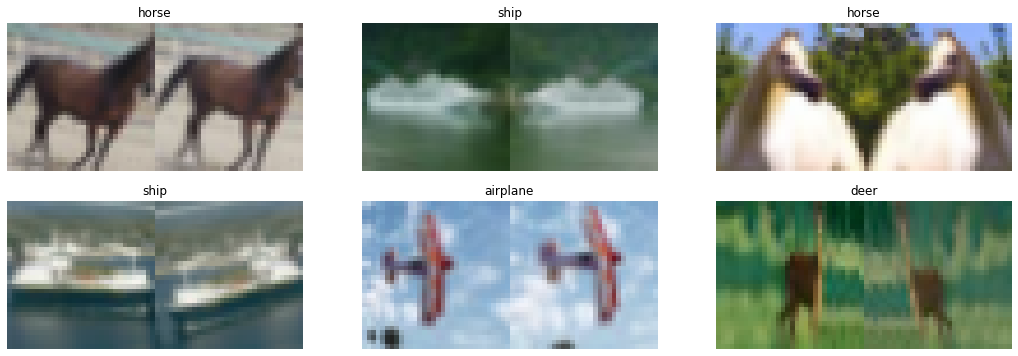

In [9]:
dls.show_batch(max_n=12)

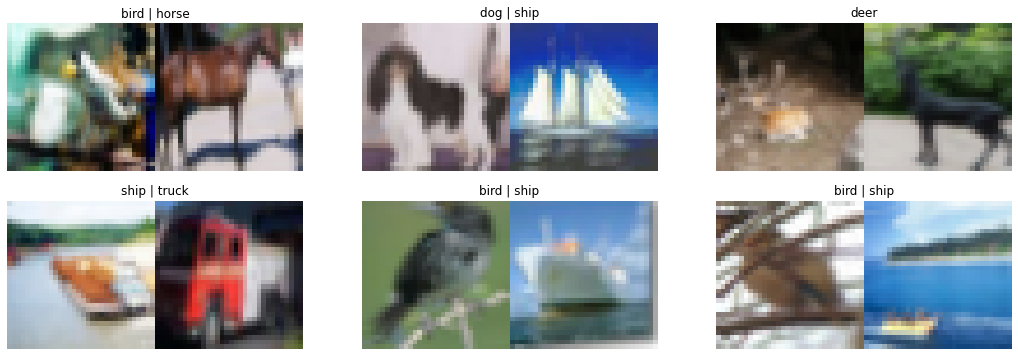

In [10]:
with double_augment.disabled(): dls.show_batch(max_n=12)

# Model

In [441]:
@module()
def L2Norm(self, x): return F.normalize(x, dim=1)

class ContrastiveModel(Module):
    def __init__(self, arch, dims=128, normalize=True, bn=False, concat_pool=False, pretrained=False):
        store_attr(but='arch')
        body = create_body(arch, pretrained=pretrained)
        pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        encoder = [body, pool, Flatten()]
        projection = [LinBnDrop(nf, nf, bn=bn, act=inplace_relu(), lin_first=True), nn.Linear(nf,dims)]
        
        if normalize: encoder.append(L2Norm()); projection.append(L2Norm())
        self.encoder = nn.Sequential(*encoder)
        self.projection = nn.Sequential(*projection)
        apply_init(self.projection)
        
    def forward(self, x): return self.projection(self.encoder(x))

ContrastMode = Enum('ContrastMode', 'All One')

class ContrastiveLoss(Module):
    def __init__(self, temp=0.07, base_temp=0.07, supervised=True, mode=ContrastMode.All, reduction='mean'):
        store_attr()
        
    def forward(self, output, target):
        embs1,embs2,lbls = output[::2],output[1::2],target[::2].view(-1,1)
        bs = lbls.size(0)
        fts = torch.cat([embs1,embs2], dim=0)
        if   self.mode == ContrastMode.All: anchor_fts,anchor_n = fts  ,2
        elif self.mode == ContrastMode.One: anchor_fts,anchor_n = embs1,1
        else: raise Exception(f'Invalid `mode`: {self.mode}')
        
        logits = (anchor_fts @ fts.T) / self.temp
        logits -= logits.max(dim=1, keepdim=True)[0].detach() # numerical stability

        mask = (lbls == lbls.T).float()
        mask = mask.repeat(anchor_n, 2)
        diagonal_mask = torch.ones_like(mask)
        torch.diagonal(diagonal_mask).fill_(0)
        mask *= diagonal_mask

        # compute log_prob
        exp_logits = logits.exp() * logits_mask
        log_prob = logits - exp_logits.sum(dim=1, keepdim=True).log()
        
        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        
        loss = -self.temp/self.base_temp * mean_log_prob_pos
        loss = loss.view(anchor_n, bs).T.contiguous().view(-1)
        if self.reduction == 'mean': loss = loss.mean()
        return loss

In [442]:
m = ContrastiveModel(resnet34)
loss_func = ContrastiveLoss()
learn = Learner(dls, m, loss_func=loss_func)

In [443]:
with torch.no_grad():
    yb_ = m.cuda()(xb)
    loss = loss_func(yb_, yb)

yb_.shape, loss

(torch.Size([1024, 128]), TensorCategory(6.9222, device='cuda:0'))

In [14]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,6.603820,7.087135,00:14
1,6.537004,7.033437,00:13
2,6.416485,7.040065,00:12
3,6.271929,7.123511,00:12
4,6.137197,7.001045,00:12
5,6.004782,6.958472,00:12
6,5.868216,6.964747,00:12
7,5.727561,7.012662,00:12
8,5.613422,6.995323,00:12
9,5.548592,6.999165,00:12


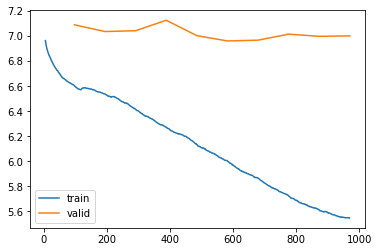

In [15]:
learn.recorder.plot_loss()

In [16]:
learn.save('cifar10')

Path('models/cifar10.pth')

In [14]:
learn.load('cifar10');

In [15]:
@typedispatch
def show_results(x:PairTensorImage, y:TensorCategory, samples, outs, ctxs=None, max_n=10, nrows=None, ncols=None,
                 figsize=None, **kwargs):
    max_n = (max_n//2)*2
    n = min(len(samples), max_n) // 2
    nrows = nrows or int(math.sqrt(n))
    ncols = ncols or int(np.ceil(n/nrows))
    figsize = figsize or (ncols*6, nrows*3.1)
    if ctxs is None: ctxs = get_grid(n, nrows=nrows, ncols=ncols, add_vert=1, figsize=figsize)
    samples,outs = [o[:max_n] for o in [samples,outs]]
    samples = L(chunked(samples[:max_n], 2)).starmap(lambda a,b: (torch.cat([a[0],b[0]], dim=2), (a[1],b[1])))
    ctxs = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(0),ctxs,range(max_n))]
    lbls = samples.itemgot(1).starmap(lambda a,b: a[0] if a[0] == b[0] else TitledStr(f'{a[0]} | {b[0]}'))
    ctxs = [b.show(ctx=c, **kwargs) for b,c,_ in zip(lbls,ctxs,range(max_n))]
    fts = torch.stack(L(outs.itemgot(0)).itemgot(1).items, dim=0)
    distances = fts[::2,None].bmm(fts[1::2,:,None]).squeeze()
    ctxs = [TitledStr(f'distance={d:.4f}').show(ctx=c, **kwargs) for d,c,_ in zip(distances,ctxs,range(max_n))]
    return ctxs

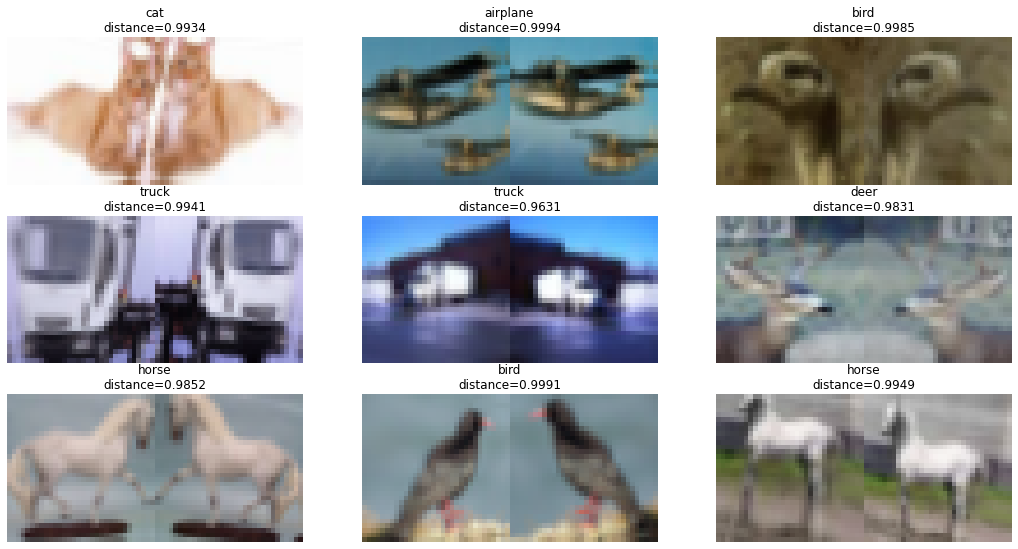

In [16]:
learn.show_results(0, max_n=18)

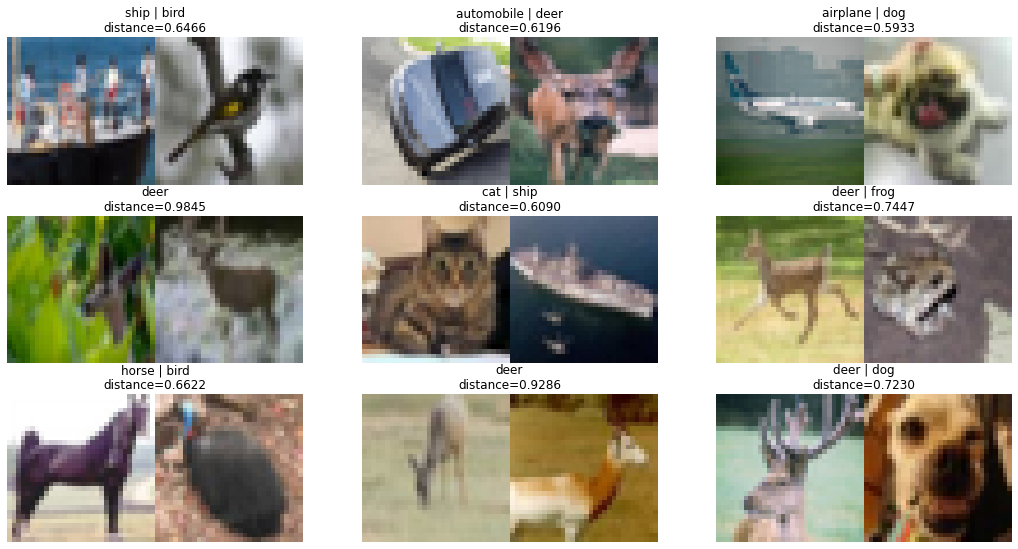

In [17]:
with double_augment.disabled(): learn.show_results(max_n=18)

# Making sense of the loss function

In [51]:
xb,yb = dls.one_batch()
with torch.no_grad(): yb_ = m.cuda()(xb)

The output of the model `yb_` are the embeddings for the images with 128 dimensions in this case:

In [52]:
yb_.shape

torch.Size([1024, 128])

Because of the `DoubleAugment` transformation our batch (`xb` and `yb`) have repeated elements (with different augmentations in `xb`):

In [53]:
yb[:10]

TensorCategory([1, 1, 9, 9, 9, 9, 8, 8, 7, 7], device='cuda:0')

## Format data

So first lets separate the embeddings corresponding to the same images and get the labels:

In [54]:
embs1,embs2,lbls = yb_[::2],yb_[1::2],yb[::2].view(-1,1)
embs1.shape,embs2.shape,lbls.shape

(torch.Size([512, 128]), torch.Size([512, 128]), torch.Size([512, 1]))

For the next steps we want to to put the embeddings together again but in a different way:
* yb_ => q,q,w,w,e,e,r,r,t,t,y,y
* fts => q,w,e,r,t,y,q,w,e,r,t,y

In [132]:
fts = torch.cat([embs1,embs2], dim=0)
fts.shape

torch.Size([1024, 128])

## Calculating distances

Now, there are 2 ways to do the calculation:
* `ContrastMode.All`: All the views of all samples are used as anchors.
* `ContrastMode.One`: Just the first view of each sample is used as an anchor.

![](imgs/pic1.png)

In this case we have 2 views, since we are doing 2 augmentations per image.
`ConstrastMode.All` will use all images as anchors and `ConstrastMode.One` will only use images of the first view as anchors.

Anchors are images that serve as reference, for each anchor we have positive and negative samples, the positives being the images with the same label.

If we use `ConstrastMode.All` then we should consider all the embeddings (`fts`) as anchors:

In [212]:
anchor_fts,anchor_n = fts,2

To calculate the distance between images we will use **cosine similarity**:
$${\text{cosine similarity}}=\cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}$$

Because the embeddings have been normalized using `L2Norm`, we can ignore the denominator part:

In [213]:
embs1[0].norm(2)

PairTensorImage(1.0000, device='cuda:0')

For the numerator, to calculate the distance we can use the dot product:
$$\mathbf {a} \cdot \mathbf {b} =\mathbf {a} \mathbf {b} ^{\mathsf {T}}$$

For the same image the distance is 1.0:

In [214]:
embs1[0] @ embs1[0].T

PairTensorImage(1.0000, device='cuda:0')

If we use 2 augmented version of the same image, as we would expect, the distance is close to 1.0:

In [215]:
embs1[0] @ embs2[0].T

PairTensorImage(0.9979, device='cuda:0')

And for different images the distance gets lower:

In [216]:
embs1[0] @ embs2[10].T

PairTensorImage(0.3339, device='cuda:0')

We calculate the distances of all anchors vs all images:

In [272]:
distances = (anchor_fts  @ fts.T)
distances.shape

torch.Size([1024, 1024])

We can check that the diagonal is highlighted as they corresponds to the same image:

In [329]:
def see_matrix(x, title=None, ax=None):
    if ax is None: fig,ax = plt.subplots(figsize=(4,4))
    if title is not None: ax.set_title(title)
    ax.imshow(x.cpu())
    ax.axis('off')

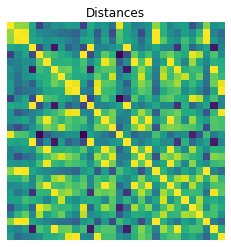

In [330]:
see_matrix(distances[:30,:30], 'Distances')

All elements in the diagonal should be 1:

In [274]:
test_close(distances.diag(), 1.)

## Getting the mask

We want images with the same label to get closer, to identify them we will build a mask matrix:

In [275]:
mask = (lbls == lbls.T).float()

To visualize the mask, lets take the 10 first elements:

In [276]:
n = 10
eg_lbls = dls.vocab.map_ids(lbls[:n].squeeze())
eg_lbls

(#10) ['automobile','truck','truck','ship','horse','dog','deer','airplane','frog','frog']

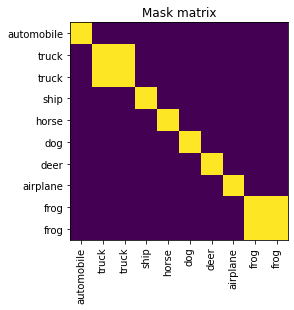

In [277]:
def see_mask():
    fig,ax = plt.subplots(figsize=(4,4))
    ax.imshow(mask[:n,:n].cpu())
    ax.set_title('Mask matrix')
    ax.set_xticks(range_of(eg_lbls)); ax.set_yticks(range_of(eg_lbls))
    ax.set_xticklabels(eg_lbls, rotation=90); ax.set_yticklabels(eg_lbls)

see_mask()

In [278]:
mask.shape, logits.shape

(torch.Size([512, 512]), torch.Size([1024, 1024]))

The mask as we have it now cannot be applied to the logits because the mask is considering 2 views and the logits 1. To fix this we can just repeat the elements in `mask`:

In [279]:
mask = mask.repeat(anchor_n, 2)
mask.shape

torch.Size([1024, 1024])

Another fix we need to do for the mask is to ignore the same elements (the diagonal):

In [280]:
diagonal_mask = torch.ones_like(mask)
torch.diagonal(diagonal_mask).fill_(0)
mask *= diagonal_mask

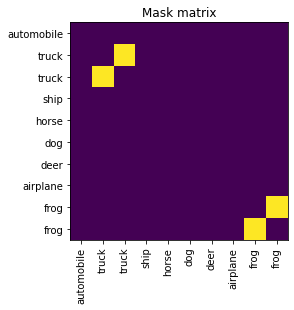

In [281]:
see_mask()

## Getting the loss

To generate the logits we apply the temperature to the distances:

In [311]:
temp = 0.07
logits = distances / temp
logits

PairTensorImage([[14.2857, 12.4233, 12.2590,  ...,  9.6239,  7.0548,  8.7349],
        [12.4233, 14.2857, 14.1228,  ...,  9.6841,  8.2144,  8.2588],
        [12.2590, 14.1228, 14.2857,  ..., 11.0027,  9.2747,  9.1594],
        ...,
        [ 9.6239,  9.6841, 11.0027,  ..., 14.2857,  8.6773,  9.1400],
        [ 7.0548,  8.2144,  9.2747,  ...,  8.6773, 14.2857, 12.8442],
        [ 8.7349,  8.2588,  9.1594,  ...,  9.1400, 12.8442, 14.2857]],
       device='cuda:0')

From the original implementation: *To improve numerical stability, subtract out the largest |logits| element in each row from all elements in that row. Since |logits| is only ever used as a ratio of exponentials of |logits| values, this subtraction does not change the results correctness. A stop_gradient() is needed because this change is just for numerical precision.*

*In pytorch we use `.detach()` instead of `stop_gradient()`.

In [315]:
logits -= logits.max(dim=1, keepdim=True)[0].detach()
logits

PairTensorImage([[ 0.0000, -1.8625, -2.0267,  ..., -4.6619, -7.2309, -5.5508],
        [-1.8625,  0.0000, -0.1629,  ..., -4.6016, -6.0714, -6.0269],
        [-2.0267, -0.1629,  0.0000,  ..., -3.2831, -5.0110, -5.1264],
        ...,
        [-4.6619, -4.6016, -3.2831,  ...,  0.0000, -5.6084, -5.1458],
        [-7.2309, -6.0714, -5.0110,  ..., -5.6084,  0.0000, -1.4415],
        [-5.5508, -6.0269, -5.1264,  ..., -5.1458, -1.4415,  0.0000]],
       device='cuda:0')

We get the exponential of the logits and apply the mask:

In [322]:
exp_logits = logits.exp() * logits_mask

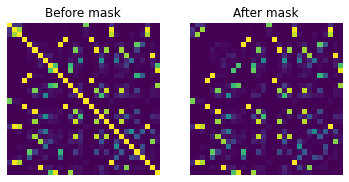

In [333]:
_,axs = subplots(1, 2)
see_matrix(logits[:30,:30].exp(), 'Before mask', axs[0])
see_matrix(exp_logits[:30,:30], 'After mask', axs[1])

Get the log probabilities:

In [560]:
log_prob = logits - exp_logits.sum(dim=1, keepdim=True).log()

What's going on here :S ?

From the paper we have (Eq. 2):
$$ \mathcal{L} = \sum_{i \in I} \frac{-1}{|P(i)|} \sum_{p \in P(i)} \log \frac{\exp \left(\boldsymbol{z}_{i} \cdot \boldsymbol{z}_{p} / \tau\right)}{\sum_{a \in A(i)} \exp \left(\boldsymbol{z}_{i} \cdot \boldsymbol{z}_{a} / \tau\right)} $$

* $i$: anchor index.
* $P(i)$: indices of all positives (same label as anchor).
* $A(i)$: all indices but $i$.
* $\boldsymbol{z_i}$: output of the model, embedding for the image $i$.
* $\tau$: temperature.

In our case we already calculated all distances and applied temperature on `logits`, so:
$$\frac{\exp (\boldsymbol{z}_{i} \cdot \boldsymbol{z}_{p} / \tau)}{\sum_{a \in A(i)} \exp (\boldsymbol{z}_{i} \cdot \boldsymbol{z}_{a} / \tau)} = \frac { \exp(\text{logits[i,p]})} {\sum_{a \in A(i)} \exp(\text{logits[i,a]})} $$

In [505]:
i = 0 # anchor index

In [506]:
i_lbl = lbls[:,0][i]; i_lbl # label for i

TensorCategory(1, device='cuda:0')

In [534]:
p = len(logits)//2; p # a positive index

512

$ \exp (\boldsymbol{z}_{i} \cdot \boldsymbol{z}_{p} / \tau) = \exp(\text{logits[i,p]})$

In [540]:
numerator = logits[i,p].exp(); numerator

PairTensorImage(0.9699, device='cuda:0')

$\sum_{a \in A(i)} \exp(\text{logits[i,a]})$

In [541]:
A = range_of(logits)
A.pop(i)
denominator = sum([logits[i,a].exp() for a in A])
denominator

PairTensorImage(103.4392, device='cuda:0')

In [562]:
numerator / denominator

PairTensorImage(0.0094, device='cuda:0')

This calculation is equivalent to the one we already did:

In [563]:
log_prob.exp()[i,p]

PairTensorImage(0.0094, device='cuda:0')

In [564]:
log_prob.shape

torch.Size([1024, 1024])

`log_prop` is a matrix with all probabilities between our samples.

`log_prob = logits - exp_logits.sum(dim=1, keepdim=True).log()`

* Since we do the subtraction on the log scale, is equivalent to the division on the formula.
* When we calculated `exp_logits`, we applied as mask `logits_mask` which turned all elements in the diagonal to $0$, so when we calculate the `sum` we ignore the same element $i$ (same as $A(i)$).

Now, if we have all probabilities then `log_prob.exp()` should sum to $1$ on each row:

In [585]:
log_prob.exp().sum(dim=1)

PairTensorImage([1.0097, 1.0106, 1.0103,  ..., 1.0083, 1.0084, 1.0061], device='cuda:0')

But, remember that we need to ignore the diagonal:

In [586]:
log_prob.exp().sum(dim=1) - log_prob.exp().diag()

PairTensorImage([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0')

We don't need all the probabilities, we only consider the positive ones, and we already have a mask for that:

In [592]:
mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
mean_log_prob_pos.shape

torch.Size([1024])

Finally we apply a temperature to the loss:

In [629]:
base_temp = 0.07
loss = - temp / base_temp * mean_log_prob_pos
loss

TensorCategory([4.9922, 5.2187, 5.2265,  ..., 5.2639, 6.4470, 7.1960], device='cuda:0')

To correctly associate the loss with the elements of the batch, we want to reshape them:
* loss before => q,w,e,r,t,y,q,w,e,r,t,y
* loss after => q,q,w,w,e,e,r,r,t,t,y,y

In [630]:
loss = loss.view(anchor_n, bs).T.contiguous().view(-1)
loss

TensorCategory([4.9922, 5.0154, 5.2187,  ..., 6.4470, 7.0823, 7.1960], device='cuda:0')

In [631]:
loss.mean()

TensorCategory(5.5120, device='cuda:0')

# Visualize embeddings

In [39]:
with double_augment.disabled(): embs,lbls = learn.get_preds()
embs.shape,lbls.shape

(torch.Size([10000, 128]), torch.Size([10000]))

In [40]:
# conda install --channel conda-forge opentsne
from openTSNE import TSNE

In [45]:
def show_embeddings(embs, lbls, highlight_lbls=None, imsize=8, cmap=plt.cm.tab20):
    _,ax = plt.subplots(figsize=(imsize,imsize))
    colors = cmap(to_np(lbls))
    ax.scatter(tsne_embs[:,0], tsne_embs[:,1], c=colors, cmap=cmap, alpha=0.7 if highlight_lbls is None else 0.1)
    if highlight_lbls is not None:
        idxs = torch.where(L([lbls==o for o in highlight_lbls]).reduce(operator.or_))[0]
        ax.scatter(tsne_embs[idxs,0], tsne_embs[idxs,1], c=colors[idxs], cmap=cmap)
    return ax

In [42]:
tsne = TSNE(metric='cosine', n_jobs=-1)
%time tsne_embs = tsne.fit(to_np(embs))

CPU times: user 2min 58s, sys: 865 ms, total: 2min 59s
Wall time: 36 s


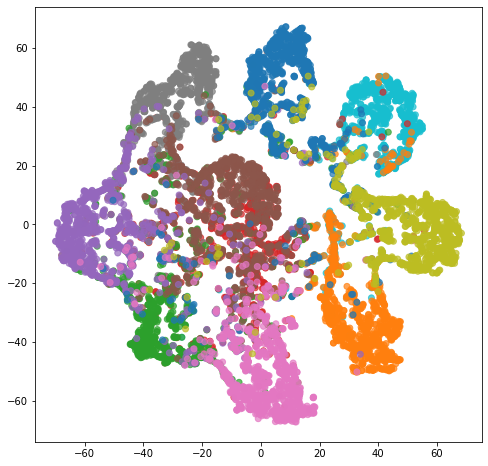

In [46]:
show_embeddings(tsne_embs, lbls, cmap=plt.cm.tab10);